# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Project for predicting breed of 133 dog breeds and deploying the model as a sagemaker endpoint.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2021-12-05 19:11:47--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.160.160
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.160.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  41.3MB/s    in 31s     

2021-12-05 19:12:21 (34.3 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

In [4]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "dogImages"

role = sagemaker.get_execution_role()

In [13]:
# upload data to s3 bucket
inputs = sagemaker_session.upload_data(path="dogImages", bucket="sagemaker-studio-0y6s2x7gps9", key_prefix="dogImages")


input spec (in this case, just an S3 path): s3://sagemaker-studio-0y6s2x7gps9/dogImages


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    IntegerParameter,
    HyperparameterTuner,
)

In [15]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameters = {
    "lr": ContinuousParameter(0.001, 0.1),
    "epochs": IntegerParameter(2,8),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512])
}

In [16]:
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [18]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameters,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [32]:
data_dir_s3 = f"s3://{bucket}/{prefix}"

In [20]:
# TODO: Fit your HP Tuner

tuner.fit(
    {'train': data_dir_s3 +'/train', 
     'test': data_dir_s3 +'/test',
     'val': data_dir_s3 +'/valid'}) 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [21]:
tuner.best_training_job()

'pytorch-training-211211-1224-008-c21048ac'

In [22]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()



2021-12-11 13:37:44 Starting - Preparing the instances for training
2021-12-11 13:37:44 Downloading - Downloading input data
2021-12-11 13:37:44 Training - Training image download completed. Training in progress.
2021-12-11 13:37:44 Uploading - Uploading generated training model
2021-12-11 13:37:44 Completed - Training job completed


In [23]:
#Get the hyperparameters of the best trained model
tuner.best_estimator().hyperparameters()


2021-12-11 13:37:44 Starting - Preparing the instances for training
2021-12-11 13:37:44 Downloading - Downloading input data
2021-12-11 13:37:44 Training - Training image download completed. Training in progress.
2021-12-11 13:37:44 Uploading - Uploading generated training model
2021-12-11 13:37:44 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"128"',
 'epochs': '8',
 'lr': '0.002911056698111383',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2021-12-11-12-24-56-646"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-554219161344/pytorch-training-2021-12-11-12-24-56-646/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [ ]:
hyperparameters = {"epochs": 8, "batch-size": 128, "lr": 0.002911056698111383}

In [7]:
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (
    Rule, 
    ProfilerRule, 
    DebuggerHookConfig, 
    rule_configs,
    ProfilerConfig, 
    FrameworkProfile,
    CollectionConfig
)

In [9]:
# TODO: Set up debugging and profiling rules and hooks
# used course resources and knwoledge center to set these parameyters
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing(), rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
# taken from  https://knowledge.udacity.com/questions/749611 for loss debugging
collection_configs=[
    CollectionConfig(name="CrossEntropyLoss_output_0",
                parameters={
                "include_regex": "CrossEntropyLoss_output_0", 
                "train.save_interval": "10","eval.save_interval": "5"}
    )
]

debug_config = DebuggerHookConfig(
    collection_configs=collection_configs
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

In [10]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-dogImages-pytorch",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=debug_config,
    profiler_config=profiler_config,
)

In [66]:
data_dir_s3

's3://sagemaker-studio-0y6s2x7gps9/dogImages'

In [14]:
estimator.fit( 
    {'train': data_dir_s3 +'/train', 
     'test': data_dir_s3 +'/test',
     'val': data_dir_s3 +'/valid'}, wait=True)

2021-12-15 20:51:34 Starting - Starting the training job...
2021-12-15 20:52:00 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2021-12-15 20:53:00 Starting - Preparing the instances for training.........
2021-12-15 20:54:26 Downloading - Downloading input data............
2021-12-15 20:56:28 Training - Downloading the training image......
2021-12-15 20:57:35 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-15 20:57:36,485 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-15 20:57:36,515 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-15 20:57:39,556 sagem

In [15]:

import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

Training jobname: smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333
Region: us-east-1
[2021-12-15 21:14:02.170 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:41 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-15 21:14:02.200 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:41 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/debug-output
[2021-12-15 21:14:05.485 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:41 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-15 21:14:06.508 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:41 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
From debugging and profiling 2 main issues were found one from profiling and one from debugging. The first one was potential issues in weight Initialization. This could be improved by using different random initialization to help the model converg and learn better. For example, using Xavier weight initialization or other random initializations availble. The other found issue from profiling was low GPU utilization. This needs to be looked at more throughly to see if all the parts have been put on cuda when running the model. There might also be issue with overfitting, for this probably I would use dropout layer so the model does not show overfitting.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?
I got LossNotDecreasing error which could also be realted to the Weight Initializtion and also the learning rate. 
To solve this issue I would use a different initialzation and lower the learning rate to see if that 
helps with decreasing loss. It would be also benefitial to change the optimizer from adam and see if that helps the situation. 

In [16]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


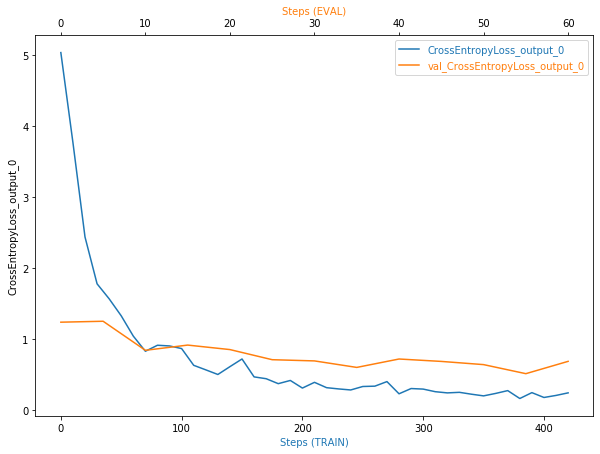

In [18]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [19]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-554219161344/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/profiler-output


Profiler data from system is available


In [20]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-12-15 21:16:14.362 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:41 INFO metrics_reader_base.py:134] Getting 20 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [21]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output


In [ ]:
# showing and loading the profiler data here in notebook

In [23]:
! aws s3 ls {rule_output_path} --recursive

2021-12-15 21:13:42     430623 smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-15 21:13:41     288089 smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-15 21:13:36        192 smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-15 21:13:36      57708 smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-15 21:13:36       1976 smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-15 21:13:36        327 smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-15 21:13:36       4423 smdebugger-dogImages-py

In [24]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-554219161344/smdebugger-dogImages-pytorch-2021-12-15-20-51-33-333/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-

In [ ]:
# got the code for profiler report from 
# https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb

In [25]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [26]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [40]:
model_path = estimator.model_data

In [41]:
model_path

's3://sagemaker-us-east-1-554219161344/model-dogImages-pytorch-2021-12-18-11-26-59-341/output/model.tar.gz'

In [39]:
# model needed to be loaded manually for some reason model didn't work and needed multiple trials
model_path = "s3://sagemaker-us-east-1-554219161344/model-dogImages-pytorch-2021-12-18-11-26-59-341/output/model.tar.gz"

In [23]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [24]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [42]:
pytorch_model = PyTorchModel(model_data=model_path, 
                             role=role, 
                             entry_point='inference.py', 
                             framework_version='1.8',
                             py_version="py36",
                             predictor_cls=ImagePredictor)

In [43]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, 
    instance_type="ml.m5.large") 

-------!

In [12]:
with open("./Border_terrier_02090.jpg", "rb") as f:
    payload = f.read()

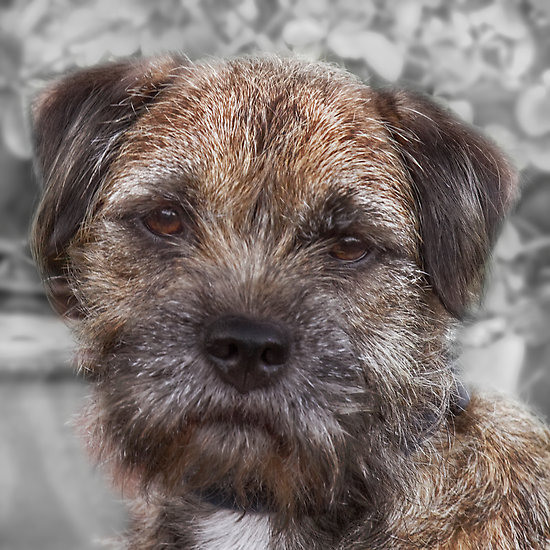

In [29]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [122]:
# loading RGB image was taken from 
# https://stackoverflow.com/questions/7762948/how-to-convert-an-rgb-image-to-numpy-array
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [123]:
image_data = load_image("Border_terrier_02090.jpg")

In [116]:
with open("Border_terrier_02090.jpg", "rb") as f:
        image_data = np.frombuffer(f.read(), np.uint8)#.astype(np.float32)

In [127]:
image_data.reshape(224,224,3)

ValueError: cannot reshape array of size 907500 into shape (224,224,3)

In [45]:
# TODO: Run an prediction on the endpoint

#image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})


In [47]:
import numpy as np

In [64]:
len(response[0])

133

In [60]:
response

[[-7.77021069,
  -8.67051706,
  -1.17172784,
  -3.55726121,
  -6.43223257,
  -2.90197279,
  -11.60094816,
  -1.3714409,
  -14.77414191,
  -15.67891697,
  -0.30035965,
  -1.21229562,
  -18.84627752,
  -6.83801155,
  -9.42352105,
  7.8471023,
  -10.60114854,
  -8.80886216,
  -18.95746496,
  -9.62126011,
  -9.11253596,
  -0.75261488,
  -7.49511521,
  5.51309462,
  -15.41480762,
  -15.78468966,
  -0.21767252,
  -7.45742053,
  8.640645,
  9.64242046,
  17.34932548,
  -9.79392031,
  -13.65954716,
  -13.66364698,
  -5.89430144,
  -14.75750143,
  -14.1179244,
  -12.91371627,
  -9.5443526,
  -11.8457749,
  -10.00138563,
  -9.78427919,
  -3.64926667,
  -12.09416919,
  -5.15829144,
  -7.74302812,
  -2.04436383,
  6.21124838,
  -1.89346784,
  -19.648394,
  -13.62481162,
  -15.78942337,
  4.27444531,
  14.17011872,
  -8.16940224,
  4.47322016,
  -2.01294171,
  -16.52442346,
  -16.34627429,
  12.64061764,
  -6.38711429,
  1.24377628,
  13.2171293,
  13.07388369,
  -15.23685557,
  2.40038455,
  -7.98

In [61]:
np.argmax(response, 1)

array([30])

In [65]:
# seems correctly predicted the Border_terrir

In [46]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()